# Prediction of Call Volume for Seattle Fire Department

Dispatching emergency calls in a city is challenging: There are large variations over a year, saison
and especially time of day. Someone has to decide how many dispatchers are on duty for every day.
Hence, we are looking for a model, which can predict the call volume for each day of the year and
each hour of the day. 

In [1]:
# Function, that writes the code in .py files
from IPython.core.magic import register_cell_magic

@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
        print("Appended to file ", file)
    else:
        print('Written to file:', file)
    with open(file, mode) as f:
        f.write(cell)        
    get_ipython().run_cell(cell)

## Preprocessing

In [2]:
%%write_and_run preprocessing.py
import pandas as pd
from datetime import datetime
from sodapy import Socrata

Written to file: preprocessing.py


First, we get the data from 'data.seattle.gov' using the Open Data API Socrata. 

In [3]:
%%write_and_run -a preprocessing.py


def get_data():
    '''
        Gets the data from data.seattle.gov past 2015
    '''
    client = Socrata("data.seattle.gov", None)

    results = client.get("kzjm-xkqj", select='Datetime', limit=int(1e7),
                         where="date_extract_y(datetime) >= 2015")

    df = pd.DataFrame.from_records(results)

    return df

Appended to file  preprocessing.py


Now, we preprocess the data, to get Features, that we can use in our model.

In [4]:
%%write_and_run -a preprocessing.py


def get_features(df, freq='h', cutoff=True):
    '''
        Produces features out of the raw data
        Parameters:
            df: raw data
            freq: frequency in which we want the data to be
                  ('h': hours, 'd': days)
            cutoff: whether to cut off the last datapoint
    '''
    # Convert Datetime column into datetime format
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    # Create Count column, which will contain the Call Volumes
    df['Count'] = df.index

    # Group the data and count the entries per frequency
    df = df.groupby(pd.Grouper(key='Datetime', freq=freq)).count()

    # We cut off the last datapoint, since it may be incomplete
    if cutoff:
        df = df[:-1]

    # Now, we create the actual features
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    if freq == 'h':
        df['Hour'] = df.index.hour
    df['DayOfYear'] = df.index.dayofyear
    df['DayOfWeek'] = df.index.dayofweek

    # Additional feature, that contains, if there is currently
    # a Covid Emergency in Seattle
    start = datetime.strptime("01-03-2020", "%d-%m-%Y")
    end = datetime.strptime("01-03-2021", "%d-%m-%Y")
    df['Covid'] = ((start <= df.index) & (df.index <= end)).astype(int)

    return df

Appended to file  preprocessing.py


In [5]:
%%write_and_run -a preprocessing.py


def get_XY(df):
    '''
        Splits the data into features and labels
    '''
    X = df.drop('Count', axis=1)
    Y = df['Count']
    return X, Y

Appended to file  preprocessing.py


## Training

In [6]:
%%write_and_run train.py
import numpy as np

from xgboost import XGBRegressor

from sklearn.model_selection import RandomizedSearchCV

from preprocessing import get_data, get_features, get_XY

Written to file: train.py


We use a Randomized Grid Search to find the best parameters for the estimator. As an estimator, we use a XGBoost Regressor. 

In [7]:
%%write_and_run -a train.py


def get_best_regressor(trainX, trainY):
    '''
        Compute the best XGBoost regressor using a Randomized Grid Search
        Parameters:
            trainX: training features
            trainY: training labels
    '''
    RSEED = 42
    # Hyperparameter grid
    param_grid = {'n_estimators': np.linspace(100, 1000).astype(int),
                  'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
                  'max_leaves': [None] + list(np.linspace(10, 50, 500).astype(int)),
                  'learning_rate': [0.001, 0.01, 0.1, 1],
                  'subsample': [0.8, 0.85, 0.9, 0.95, 1]
                  }

    # Estimator for use in random search
    estimator = XGBRegressor(random_state=RSEED)

    # Create the random search model
    rs = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=3,
                            n_iter=10, verbose=5, random_state=RSEED)

    # Fit
    rs.fit(trainX, trainY)

    print('best parameters for estimator: ', rs.best_params_)

    return rs.best_estimator_

Appended to file  train.py


Now, we want to run the functions to get the model.

In [8]:
%%write_and_run -a train.py


def main():
    # Get the Data
    data = get_data()
    # Get the Features
    df = get_features(data)
    X, Y = get_XY(df)
    # Get the model
    model = get_best_regressor(X, Y)
    # Save the model
    model.save_model('model.json')


if __name__ == "__main__":
    main()

Appended to file  train.py
Fitting 3 folds for each of 10 candidates, totalling 30 fits
best parameters for estimator:  {'subsample': 0.9, 'n_estimators': 430, 'max_leaves': 22, 'max_depth': 4, 'learning_rate': 0.1}


c:\Users\User\Documents\Projects\Prediction-of-Call-Volume-for-Seattle-Fire-Department-Challenge\.venv\lib\site-packages\xgboost\sklearn.py:722: UserWarning: n_estimators is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)
c:\Users\User\Documents\Projects\Prediction-of-Call-Volume-for-Seattle-Fire-Department-Challenge\.venv\lib\site-packages\xgboost\sklearn.py:722: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)
c:\Users\User\Documents\Projects\Prediction-of-Call-Volume-for-Seattle-Fire-Department-Challenge\.venv\lib\site-packages\xgboost\sklearn.py:722: UserWarning: max_leaves is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)


# Predicting

In [9]:
%%write_and_run predict.py
import pandas as pd

from xgboost import XGBRegressor

import sys

from datetime import datetime

from preprocessing import get_features, get_XY

Written to file: predict.py


To make predictions for the future, we need some input for the model.

In [10]:
%%write_and_run -a predict.py


def get_testX(start_date, date_range=30):
    '''
        Produces forecast input for the model.
        Parameters:
            start_date: start_date of the test data
            date_range: number of days to forecast
    '''
    test_range = pd.date_range(start_date, periods=date_range*24, freq='h')
    df_test_range = pd.DataFrame(test_range, columns=['Datetime'])
    df_test = get_features(df_test_range, cutoff=False)
    X, Y = get_XY(df_test)
    return X

Appended to file  predict.py


Now, let's load the model and make some predictions.

In [11]:
%%write_and_run -a predict.py


def main(start_date, date_range):
    # Load the model
    model = XGBRegressor()
    model.load_model('model.json')

    # Get the input
    testX = get_testX(start_date=start_date, date_range=date_range)
    # Make predictions
    pred = model.predict(testX)

    # Print Prediction
    print('Prediction for', testX.index[0], ': ', pred[0])

    # Save predictions
    testX['pred'] = pred
    df_test = testX['pred']
    df_test.to_csv('results.csv')
    print(date_range, 'days of predictions saved in results.csv')


if __name__ == "__main__":
    # Try to load the date from the system args
    try:
        start_date = datetime.strptime(str(sys.argv[1]), "%d-%m-%Y:%H")
    except:
        print('invalid date, will use now')
        start_date = datetime.now()
        start_date = start_date.replace(minute=0, second=0, microsecond=0)
    
    # Try to load the forecast range from the system args
    try:
        date_range = int(sys.argv[2])
    except:
        print('invalid number, will forecast one day')
        date_range = 1
    main(start_date, date_range)

Appended to file  predict.py
invalid date, will use now
invalid number, will forecast one day
Prediction for 2022-09-28 17:00:00 :  18.061214
1 days of predictions saved in results.csv


# Testing

To evaluate the model, we want to train the model on a smaller subset and test it on an unseen subset. 

In [12]:
%%write_and_run test.py
import numpy as np

from datetime import datetime
from preprocessing import get_data, get_features, get_XY
from train import get_best_regressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Written to file: test.py


First, we want to make the train test split.

In [13]:
%%write_and_run -a test.py


def get_train_test_split(df, split):
    '''
        Splits the data in train and test subsets.
        Parameters:
            df: data to split
            split: Datetime where the data is split
    '''
    dftrain = df[df.index < split]
    dftest = df[df.index >= split]

    trainX, trainY = get_XY(dftrain)
    testX, testY = get_XY(dftest)
    return trainX, trainY, testX, testY

Appended to file  test.py


Now, we actually run the functions to get predictions.

In [14]:
%%write_and_run -a test.py


# Get the Data
data = get_data()
# Get the Features
df = get_features(data)
# Get the Train Test Split
trainX, trainY, testX, testY = get_train_test_split(df, split=datetime.strptime("01-08-2022", "%d-%m-%Y"))

# Get the model
model = get_best_regressor(trainX, trainY)

# Make predictions
pred_test = model.predict(testX)
pred_train = model.predict(trainX)

# Calculate Errors
#print('RSME on training set: ', mean_squared_error(trainY, pred_train, squared=False))
print('MAE on training set: ', mean_absolute_error(trainY, pred_train))
print('R^2 on training set: ', r2_score(trainY, pred_train))
#print('RSME on test set: ', mean_squared_error(testY, pred_test, squared=False))
print('MAE on test set: ', mean_absolute_error(testY, pred_test))
print('R^2 on test set: ', r2_score(testY, pred_test))

# Save predictions
df['pred'] = np.concatenate([pred_train, pred_test])
df = df[['pred', 'Count']]
df.to_csv('predictions_test.csv')

Appended to file  test.py
Fitting 3 folds for each of 10 candidates, totalling 30 fits
best parameters for estimator:  {'subsample': 0.9, 'n_estimators': 430, 'max_leaves': 22, 'max_depth': 4, 'learning_rate': 0.1}
MAE on training set:  2.793384385149129
R^2 on training set:  0.5169508537775048
MAE on test set:  3.424296520778111
R^2 on test set:  0.3810450308956329


## Evaluation

Now, we have predictions. We already have the MAE and the R^2 values. The MAE tells us, how far the prediction is in average away from the actual Call Volume. This seems quite good. The R^2 value on the test set is quite low, this means that the model does not account very much of the variance. This is fine, since we have a lot of variance in the data. So, let's have a closer look at the results.

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]

def plot_results(df, split, offset1, offset2=-1):
    '''
        Plots the results
        Parameters:
            df: data to plot
            split: length of the training samples
            offset1: offset for the left border 
                     (negative values will show train data)
            offset2: offset for the right border
                     (-1 will show all values)
    '''
    if offset2 == -1:
        offset2 -= split
    sns.lineplot(df[split+offset1:split+offset2], x=df.index[split+offset1:split+offset2], y='Count', label='Call Volume')
    sns.lineplot(df[split+offset1:split+offset2], x=df.index[split+offset1:split+offset2], y='pred', label='Prediction')
    if offset1 < 0:
        plt.axvline(x=df.index[split], color='r')
    plt.xticks(rotation=90)

In the next plot, we see the prediction for the full Month August. The red line seperates the training set from the testing set. 

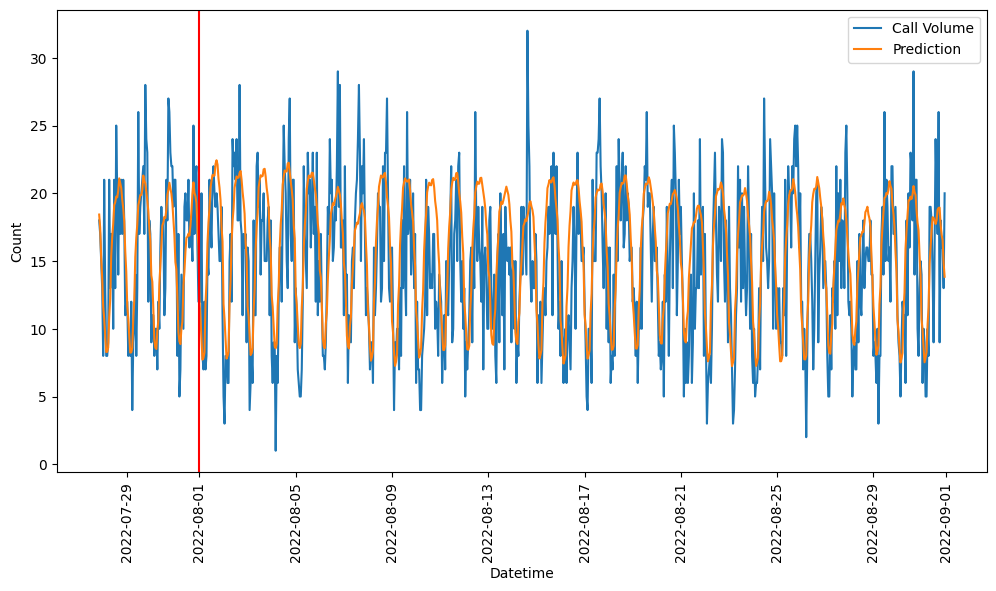

In [16]:
plot_results(df, len(trainX), -100, 31*24)

Let's have a closer look. The next plot shows the prediction only for the first week. 

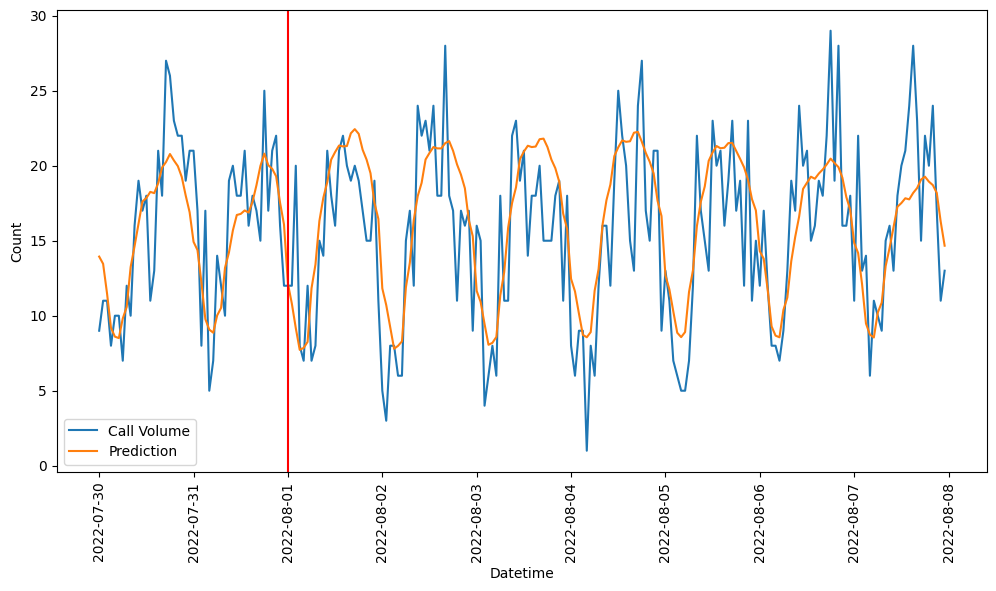

In [17]:
plot_results(df, len(trainX), -24*2, 24*7)

Seems like the Prediction fits the Call Volumes pretty good.

# Predict Call Volumes per day

If we want to forecast further into the future, it may make more sense to look at the daily Call Volumes instead of the hourly.

In [18]:
df_days = get_features(data, freq='d')
trainX, trainY, testX, testY = get_train_test_split(df_days, split = datetime.strptime("01-09-2021", "%d-%m-%Y"))
model = get_best_regressor(trainX, trainY)

pred_test = model.predict(testX)
pred_train = model.predict(trainX)

print('MAE on test set: ', mean_absolute_error(testY, pred_test))
print('R^2 on test set: ', r2_score(testY, pred_test))

df_days['pred'] = np.concatenate([pred_train, pred_test])


Fitting 3 folds for each of 10 candidates, totalling 30 fits
best parameters for estimator:  {'subsample': 0.9, 'n_estimators': 430, 'max_leaves': 22, 'max_depth': 4, 'learning_rate': 0.1}
MAE on test set:  31.453997164356466
R^2 on test set:  -0.46985312247593836


In the next plot, we can see the forecast for one year.

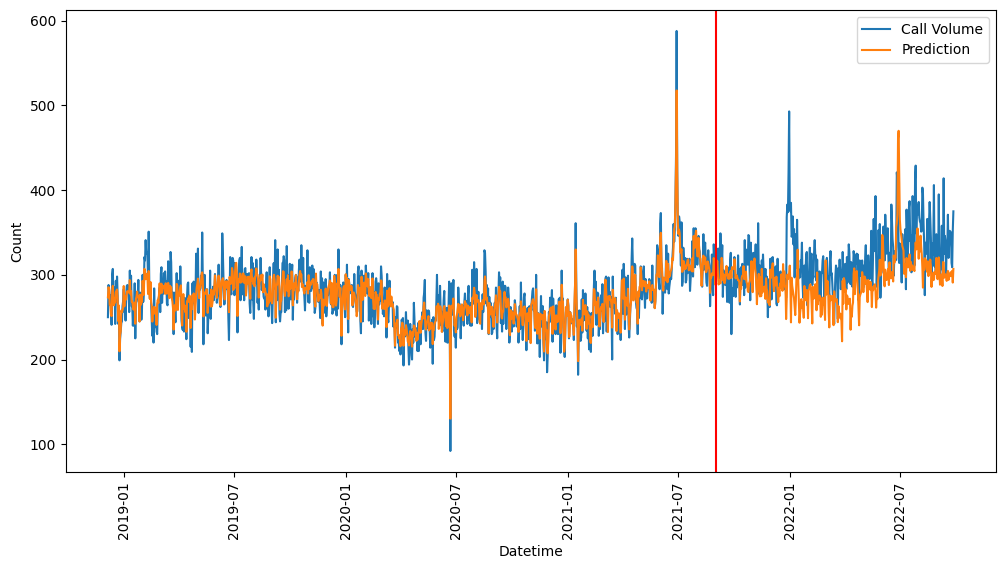

In [19]:
plot_results(df_days, len(trainX), -1000)

We can see, that the model has some difficulties in forecasting the daily Call Volumes accurately in the more farer future. Daily Call Volumes seem to be more random and in general it is just more difficult to forecast such a long time. 

# Conclusion

In this notebook, we built a model that can accurately forecast the hourly Call Volumes in the next weeks to months. 

Forecasting Call Volumes in the far future, like one year, is quite difficult since there are more factors that play a role. 